# データ読込

/Users/k.takeuchi/Documents/whitepaper/iap-analytics/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


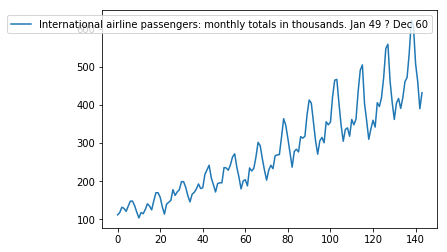

In [1]:
#データは以下からダウンロード
#https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("international-airline-passengers.csv", skipfooter=3)
df.plot()

# 前処理

## 定常化

In [2]:
#乗客数データのみ取り出す
passenger = np.array(df.iloc[:, 1].astype('float32'))

In [3]:
#配列をズラす
def shift(data, n = 1):
    X = data[:-n]
    y = data[n:]
    
    return X, y

#階差をとる
def difference(data, n = 1):
    d1, d2 = shift(data, n)
    diffed = d2 - d1
    return diffed

#階差を戻す
def inv_diff(base, diff, n = 1):
    inv = np.zeros_like(diff)

    for i in range(len(diff)):
        if i <= n  - 1:
            inv[i] = base[i]
        else:
            inv[i] = inv[i - n] + diff[i - n]
            
    return inv

(-2.7095756231960424, 0.07239587509991267, 12, 119, {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}, -424.76083199566506)


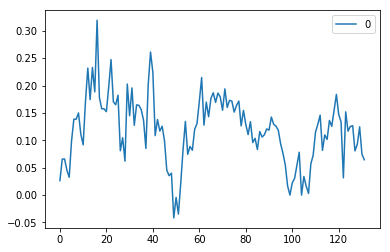

In [4]:
#線形トレンド、季節性を除去
pd.DataFrame(difference(np.log(passenger), 12)).plot()

#定常性の確認
from statsmodels.tsa import stattools
print(stattools.adfuller(difference(np.log(passenger), 12)))

In [5]:
#定常化
passenger_log = np.log(passenger)
passenger_log_d1 = difference(passenger_log, 12)
X_d, y_d = shift(passenger_log_d1, 1)

## データの分割


In [6]:
from sklearn.model_selection import train_test_split

X_d_train, X_d_val, y_d_train, y_d_val = train_test_split(X_d, y_d, test_size = 0.3, shuffle = False)

## 正規化

In [7]:
from sklearn.preprocessing import MinMaxScaler

#正規化
sclr_x = MinMaxScaler(feature_range=(0, 1))
sclr_y = MinMaxScaler(feature_range=(0, 1))

X_d_train = sclr_x.fit_transform(X_d_train.reshape(-1, 1))
X_d_val = sclr_x.transform(X_d_val.reshape(-1, 1))

y_d_train = sclr_y.fit_transform(y_d_train.reshape(-1, 1))
y_d_val = sclr_y.transform(y_d_val.reshape(-1, 1))

## RNNに入れる形に変換

In [8]:
# データ変換
def convert_rnn_input(X, y, ws = 1, dim = 1):
    data = []
    target = []
    
    #windowサイズが1の場合は全部のデータを使う
    #そうでない場合は、wsで全てのデータが収まる範囲で使う
    if(ws == 1):
        itr = len(X)
    else:
        itr = len(X) - ws
    
    for i in range(itr):
        data.append(X[i: i + ws])
        target.append(y[i: i + ws])
        
    # データの整形
    data = np.array(data).reshape(len(data), ws, dim)
    target = np.array(target).reshape(len(data), ws, dim)
        
    return data, target

#windowサイズ1の形で変換
X_train_c, y_train_c = convert_rnn_input(X_d_train, y_d_train, 1, 1)
X_val_c, y_val_c = convert_rnn_input(X_d_val, y_d_val, 1, 1)

# 学習

In [9]:
import keras
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.wrappers import Bidirectional

Using TensorFlow backend.


In [10]:
#モデル設定
main_input = Input(shape=(X_train_c.shape[1], X_train_c.shape[2]),
                   dtype='float32',
                   batch_shape = (1, X_train_c.shape[1], 1), 
                   name='main_input')

out = LSTM(8, return_sequences = True, stateful = True, activation='tanh')(main_input)
out = LSTM(16, stateful = True, activation='tanh', return_sequences = True)(out)
main_output = TimeDistributed(Dense(1, activation='linear', name='output'))(out)

model = Model(inputs=[main_input], outputs=[main_output])
model.compile(loss="mse", optimizer=Adam())

In [13]:
batch_size = 1
n_epoch = 20

#loss保存用
log_loss = np.zeros(n_epoch)
log_val_loss = np.zeros(n_epoch)
models = []

#学習開始
for i in range(n_epoch):
    res = model.fit(X_train_c, y_train_c, batch_size = batch_size, 
          epochs = 1, validation_data=(X_val_c, y_val_c), verbose = 1, 
                    shuffle = False)
    
    #lossを保存
    log_loss[i] = res.history['loss'][0]
    log_val_loss[i] = res.history['val_loss'][0]
    models.append(res)
    
    model.reset_states() #毎回sateをリセット

Train on 91 samples, validate on 40 samples
Epoch 1/1
91/91 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0484
Train on 91 samples, validate on 40 samples
Epoch 1/1
91/91 [==============================] - 0s 5ms/step - loss: 0.0141 - val_loss: 0.0330
Train on 91 samples, validate on 40 samples
Epoch 1/1
91/91 [==============================] - 0s 4ms/step - loss: 0.0131 - val_loss: 0.0492
Train on 91 samples, validate on 40 samples
Epoch 1/1
91/91 [==============================] - 0s 4ms/step - loss: 0.0151 - val_loss: 0.0334
Train on 91 samples, validate on 40 samples
Epoch 1/1
91/91 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0480
Train on 91 samples, validate on 40 samples
Epoch 1/1
91/91 [==============================] - 0s 4ms/step - loss: 0.0153 - val_loss: 0.0268
Train on 91 samples, validate on 40 samples
Epoch 1/1
91/91 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.0351
Train on 91 s

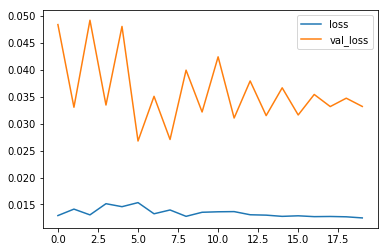

In [14]:
#loss可視化
loss_df = pd.DataFrame([log_loss, log_val_loss]).T
loss_df.columns = ["loss", "val_loss"]
loss_df.plot()

In [15]:
#validationで一番良い精度のモデルを選択
print(np.argsort(log_val_loss[log_val_loss > 0])[0])
print(np.argsort(log_loss)[0])
best_model = models[np.argsort(log_val_loss[log_val_loss > 0])[0]].model

5
19


# 予測

In [16]:
#各予測に予測結果を使う
def pred_by_pred_data(model, X, time):
    model.reset_states()
    
    prediction_train = np.zeros(len(X))
    prediction = np.zeros(time)
        
    #train分まず予測する
    for i in range(len(X)):
        prediction_train[i] = model.predict(X[i].reshape(1,-1,1))[0][0][0]
    
    #学習データの最後の値から予測していく
    tmp = X[len(X) - 1, :, :].reshape(1,-1,1)[0, 1:, 0]
    tmp = np.append(tmp, prediction_train[len(X) - 1]).reshape(1,-1,1)
    
    #指定期間先まで予測
    for i in range(time):
        prediction[i] = model.predict(tmp)[0][0][0]
        
        #次に予測に使うデータを更新
        tmp = tmp[0, 1:, 0]
        tmp = np.append(tmp, prediction[i]).reshape(1,-1,1)
    
    model.reset_states()
    
    return np.hstack((prediction_train, prediction))

(171, 1)


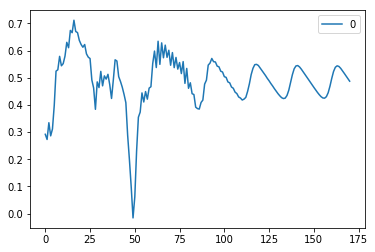

In [17]:
#予測
predicted = pred_by_pred_data(best_model, X_train_c, 80)
predicted = pd.DataFrame(predicted)
print(predicted.shape)
predicted.plot()

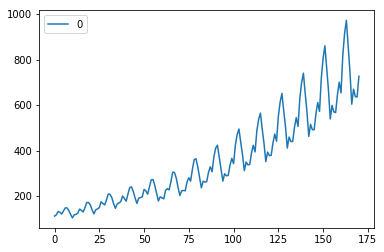

In [18]:
#正規化を戻して可視化
predicted_inv = sclr_y.inverse_transform(np.array(predicted).reshape(-1, 1))
predicted_inv = inv_diff(passenger_log, predicted_inv, 12)
predicted_inv = pd.DataFrame(np.exp(predicted_inv))
predicted_inv.plot()

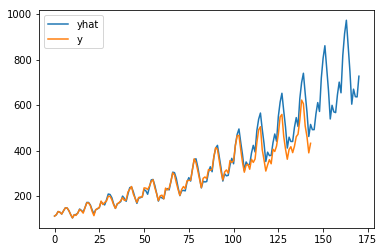

In [19]:
#真の値と重ねて可視化
predicted_inv = sclr_y.inverse_transform(np.array(predicted).reshape(-1, 1))
predicted_inv = np.exp(inv_diff(passenger_log, predicted_inv, 12))
predicted_inv = pd.DataFrame(predicted_inv)

#真の値と同じデータフレームに
df_viz = pd.concat([np.round(predicted_inv), pd.DataFrame(passenger)], axis = 1)
df_viz.columns = ["yhat", "y"]
df_viz.plot()

In [20]:
#精度
(df_viz.iloc[103:144, :].iloc[:, 1] - df_viz.iloc[103:144, :].iloc[:, 0]).abs().mean()

58.68292682926829